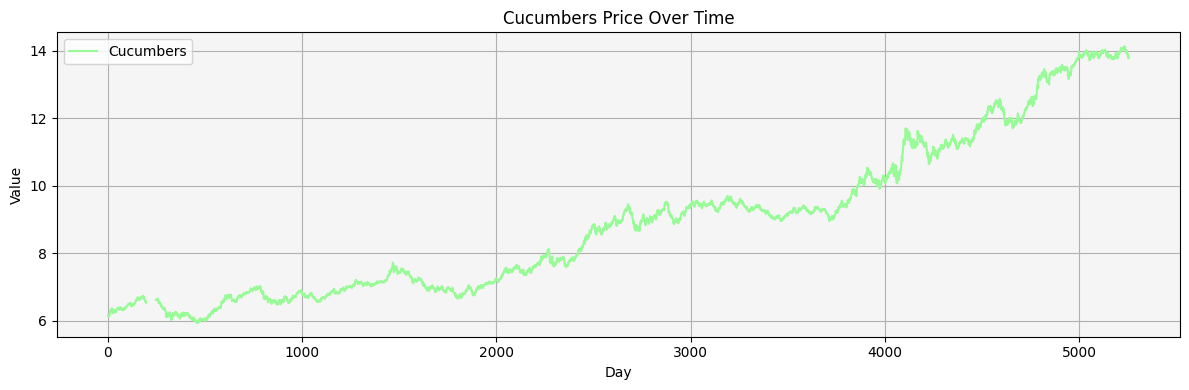

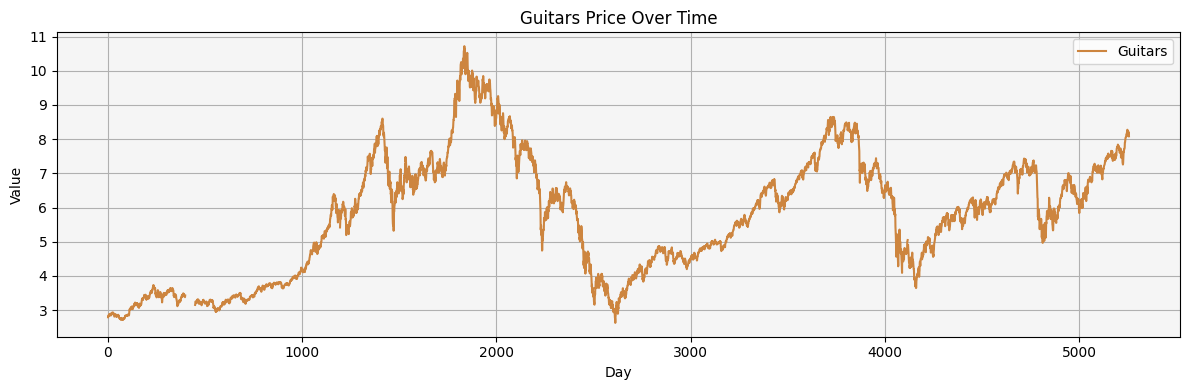

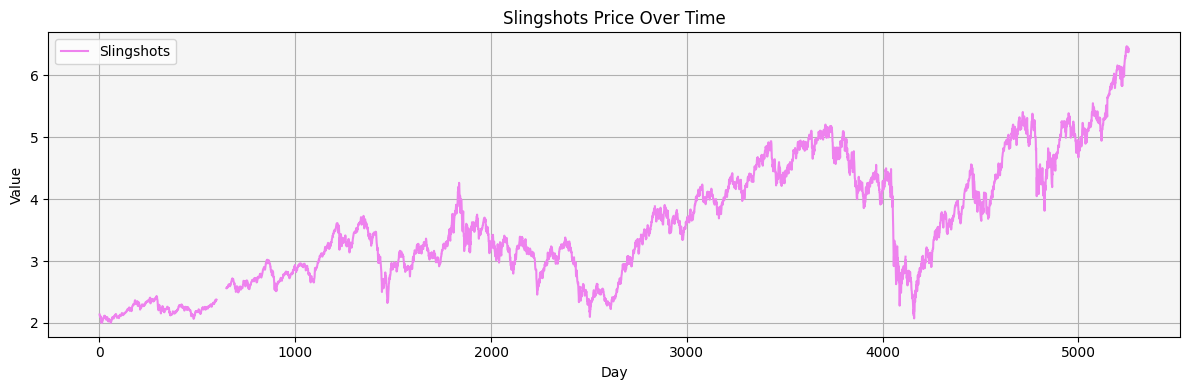

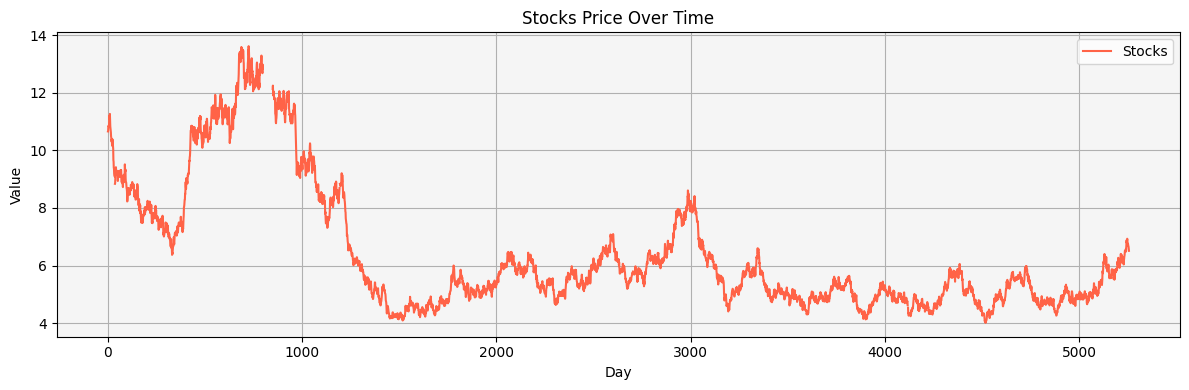

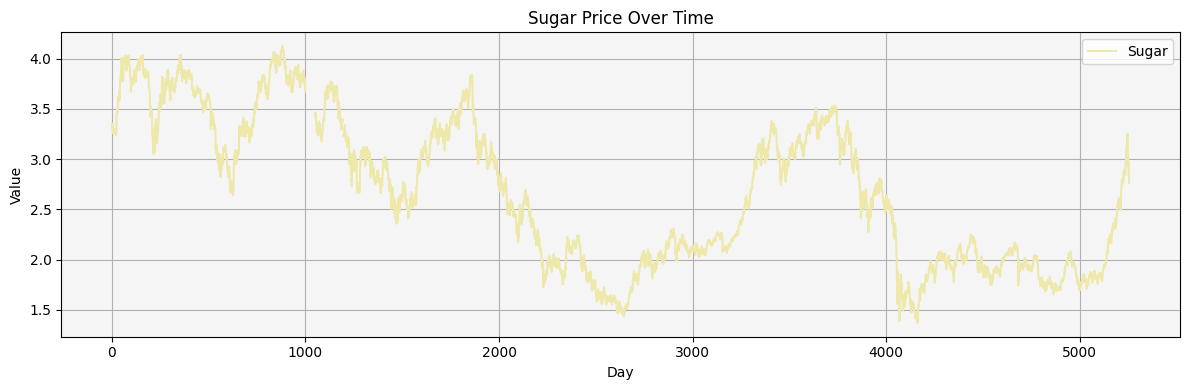

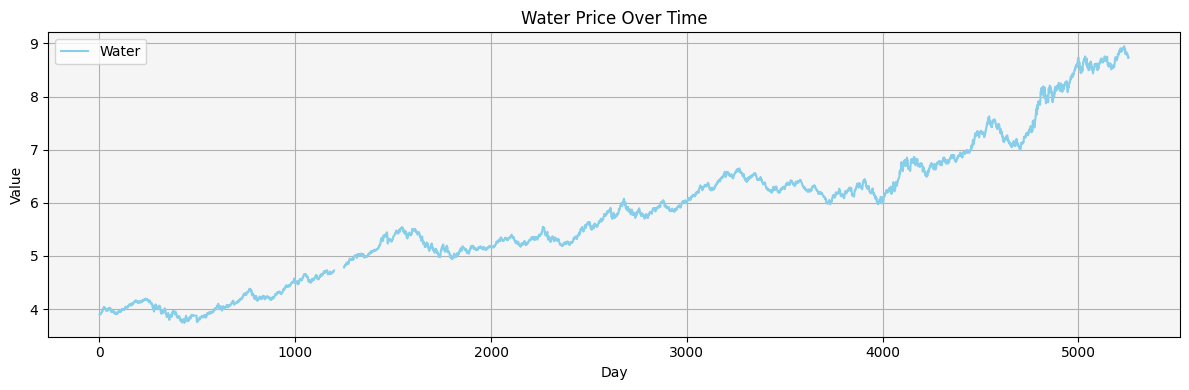

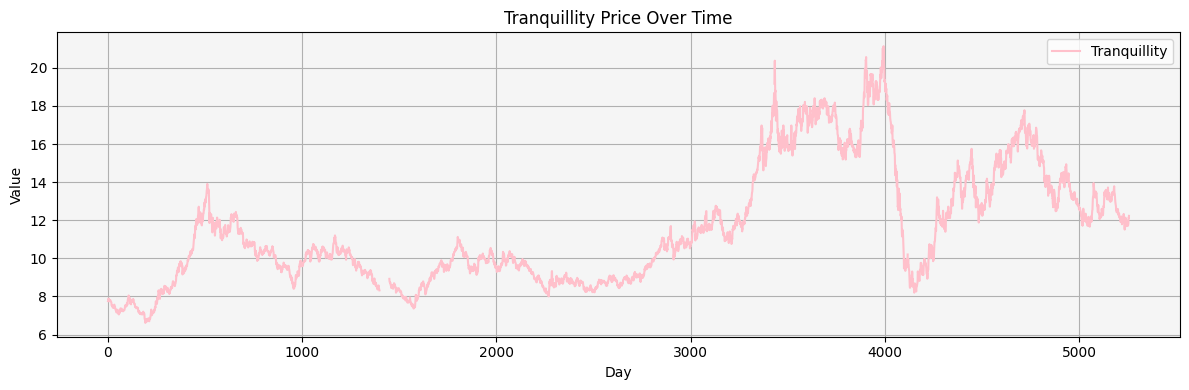

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model

colours = {
    'cucumbers': 'palegreen',
    'guitars': 'peru',
    'slingshots': 'violet',
    'stocks': 'tomato',
    'sugar': 'palegoldenrod',
    'water': 'skyblue',
    'tranquillity': 'pink'
}

# === Load and Clean Data ===
df = pd.read_csv("spiff_data.csv")
df = df.dropna(how='all', axis=1).dropna(how='all', axis=0)
df.replace(1000, np.nan, inplace=True)
df=df.drop(columns='Unnamed: 0')
df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
# Save the cleaned dataframe to a new CSV file
df.to_csv('spiff_data_cleaned.csv', index=False)

#while df.iloc[-1, 1:].isnull().all():  # Check if all columns except the first are empty in the last row
#    df = df.iloc[:-1]  # Remove the last row
    
#df.to_csv('spiff_data_cleaned_croped.csv', index=False)

#df = df.interpolate(method='linear', limit_direction='both') 
#df = df.fillna(method='ffill')

#df.to_csv('spiff_data_cleaned_croped_filed.csv', index=False)

# === Compute Log Returns ===
log_returns = np.log(df / df.shift(1))

# Create a separate plot for each column
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    plt.plot(df['day'], df[column], color=color, label=column.capitalize())
    plt.title(f'{column.capitalize()} Price Over Time')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.gca().set_facecolor("whitesmoke")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [2]:
df.head()

,day,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
0,1.0,6.154653,2.794285,2.136536,10.653684,3.324896,3.896149,7.755880
1,2.0,6.189623,2.843068,2.113582,10.674465,3.355736,3.899915,7.781310
2,3.0,6.168641,2.839644,2.116336,10.822372,3.336461,3.897404,7.886205
3,4.0,6.156401,2.823384,2.096137,10.848804,3.288274,3.901170,7.848061
4,5.0,6.124929,2.832798,2.099810,10.860731,3.303694,3.905355,7.883026


In [3]:
summary_stats = df.describe()
summary_stats

,day,cucumbers,guitars,slingshots,stocks,sugar,water,tranquillity
count,5455.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000,5201.000000
mean,2728.816865,8.934701,5.758999,3.562496,6.354767,2.663530,5.794586,11.552924
std,1575.126349,2.268289,1.756993,0.973406,2.139400,0.727010,1.275024,3.067634
min,1.000000,5.942896,2.629048,2.001362,4.012346,1.370262,3.739412,6.614749
25%,1365.500000,6.947150,4.252728,2.804869,4.916920,1.999030,4.996563,9.186268
50%,2729.000000,8.905505,5.907840,3.383130,5.520531,2.605522,5.774852,10.584870
75%,4092.500000,10.183919,7.055568,4.291411,6.946382,3.279982,6.488217,13.380483
max,5456.000000,14.132395,10.719387,6.468982,13.613052,4.125193,8.949187,21.137953


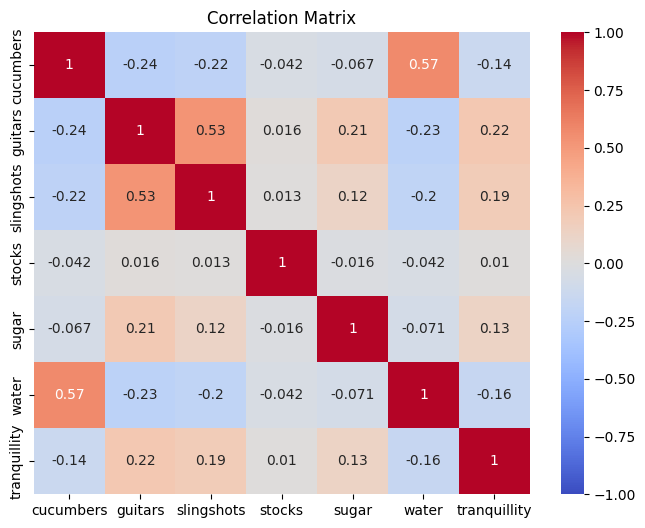

In [4]:
df=df.dropna()
plt.figure(figsize=(8,6))
sns.heatmap(log_returns.drop(columns='day').corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

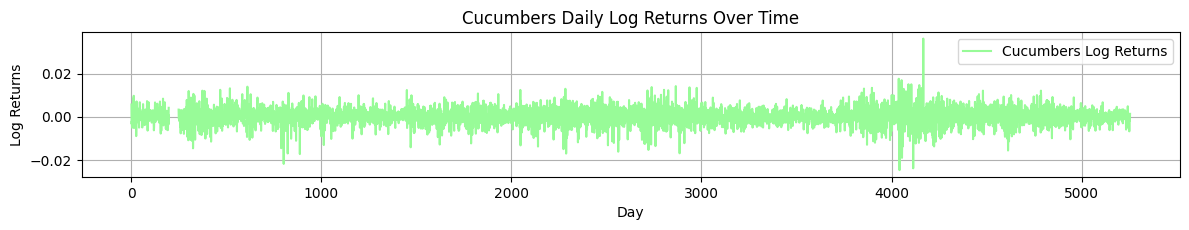

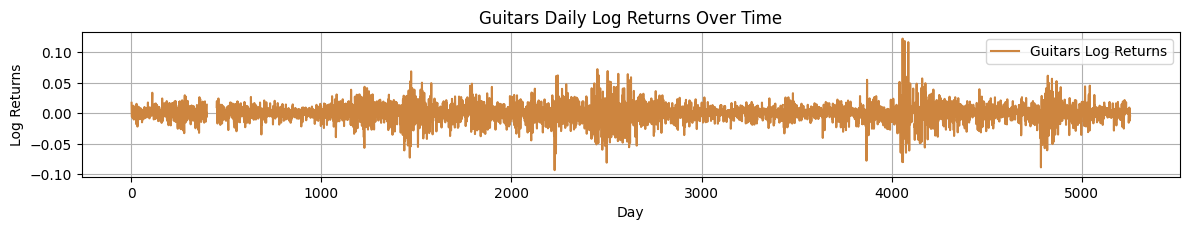

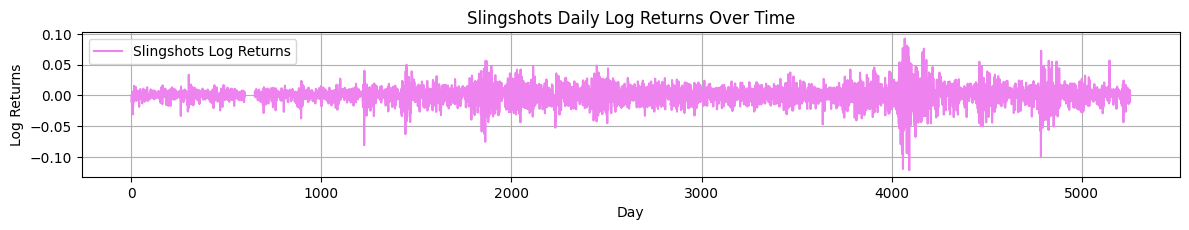

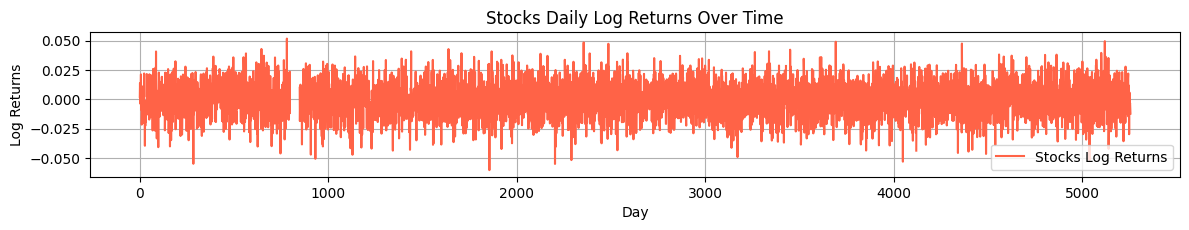

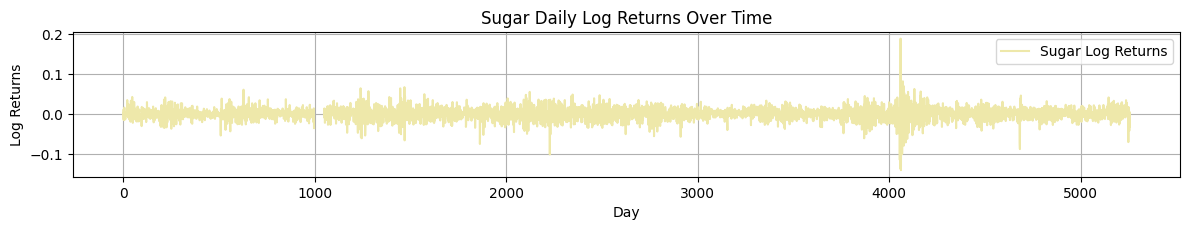

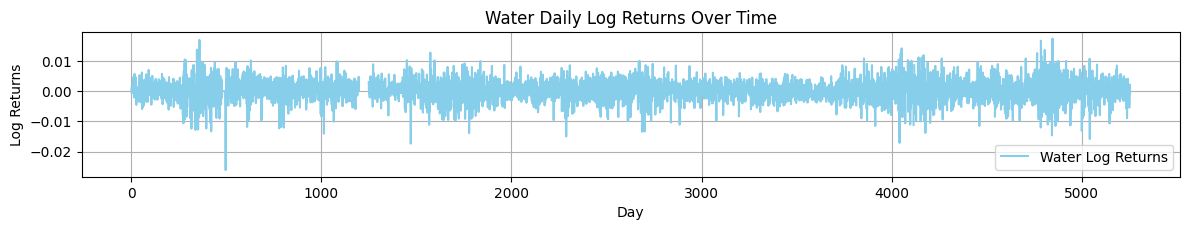

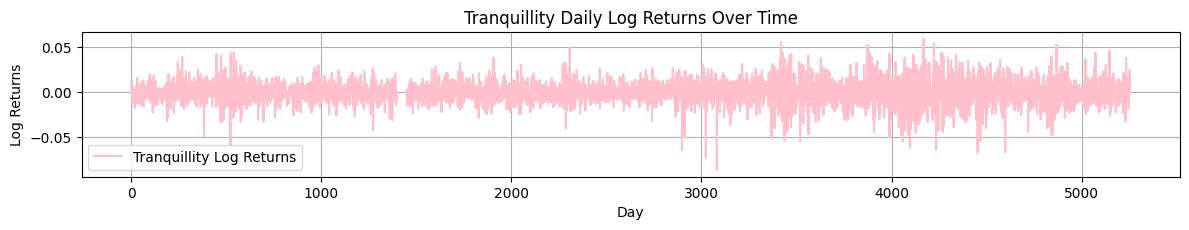

In [5]:
# Loop through each column for plotting
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    # Plot log returns
    plt.subplot(2, 1, 2)
    plt.plot(log_returns[column], color=color, label=f'{column.capitalize()} Log Returns')
    plt.title(f'{column.capitalize()} Daily Log Returns Over Time')
    plt.xlabel('Day')
    plt.ylabel('Log Returns')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

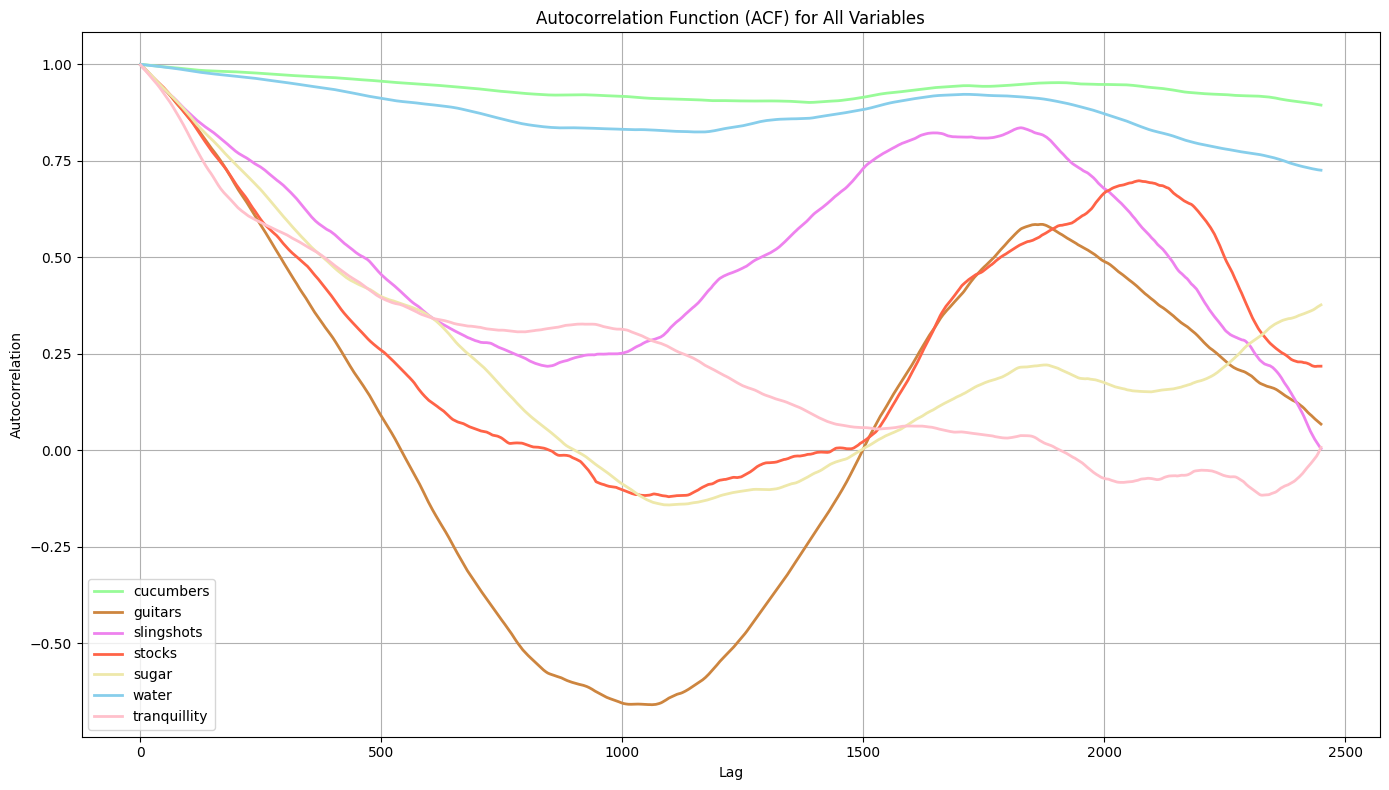

In [6]:
# === Plot autocorrelations for all columns ===
plt.figure(figsize=(14, 8))
max_lag = len(df) // 2

for i, column in enumerate(colours.keys()):
    series = df[column].dropna()
    autocorrelations = [series.autocorr(lag) for lag in range(1, max_lag + 1)]
    plt.plot(range(1, max_lag + 1), autocorrelations, label=column, color=colours[column], linewidth=2)

plt.title('Autocorrelation Function (ACF) for All Variables')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

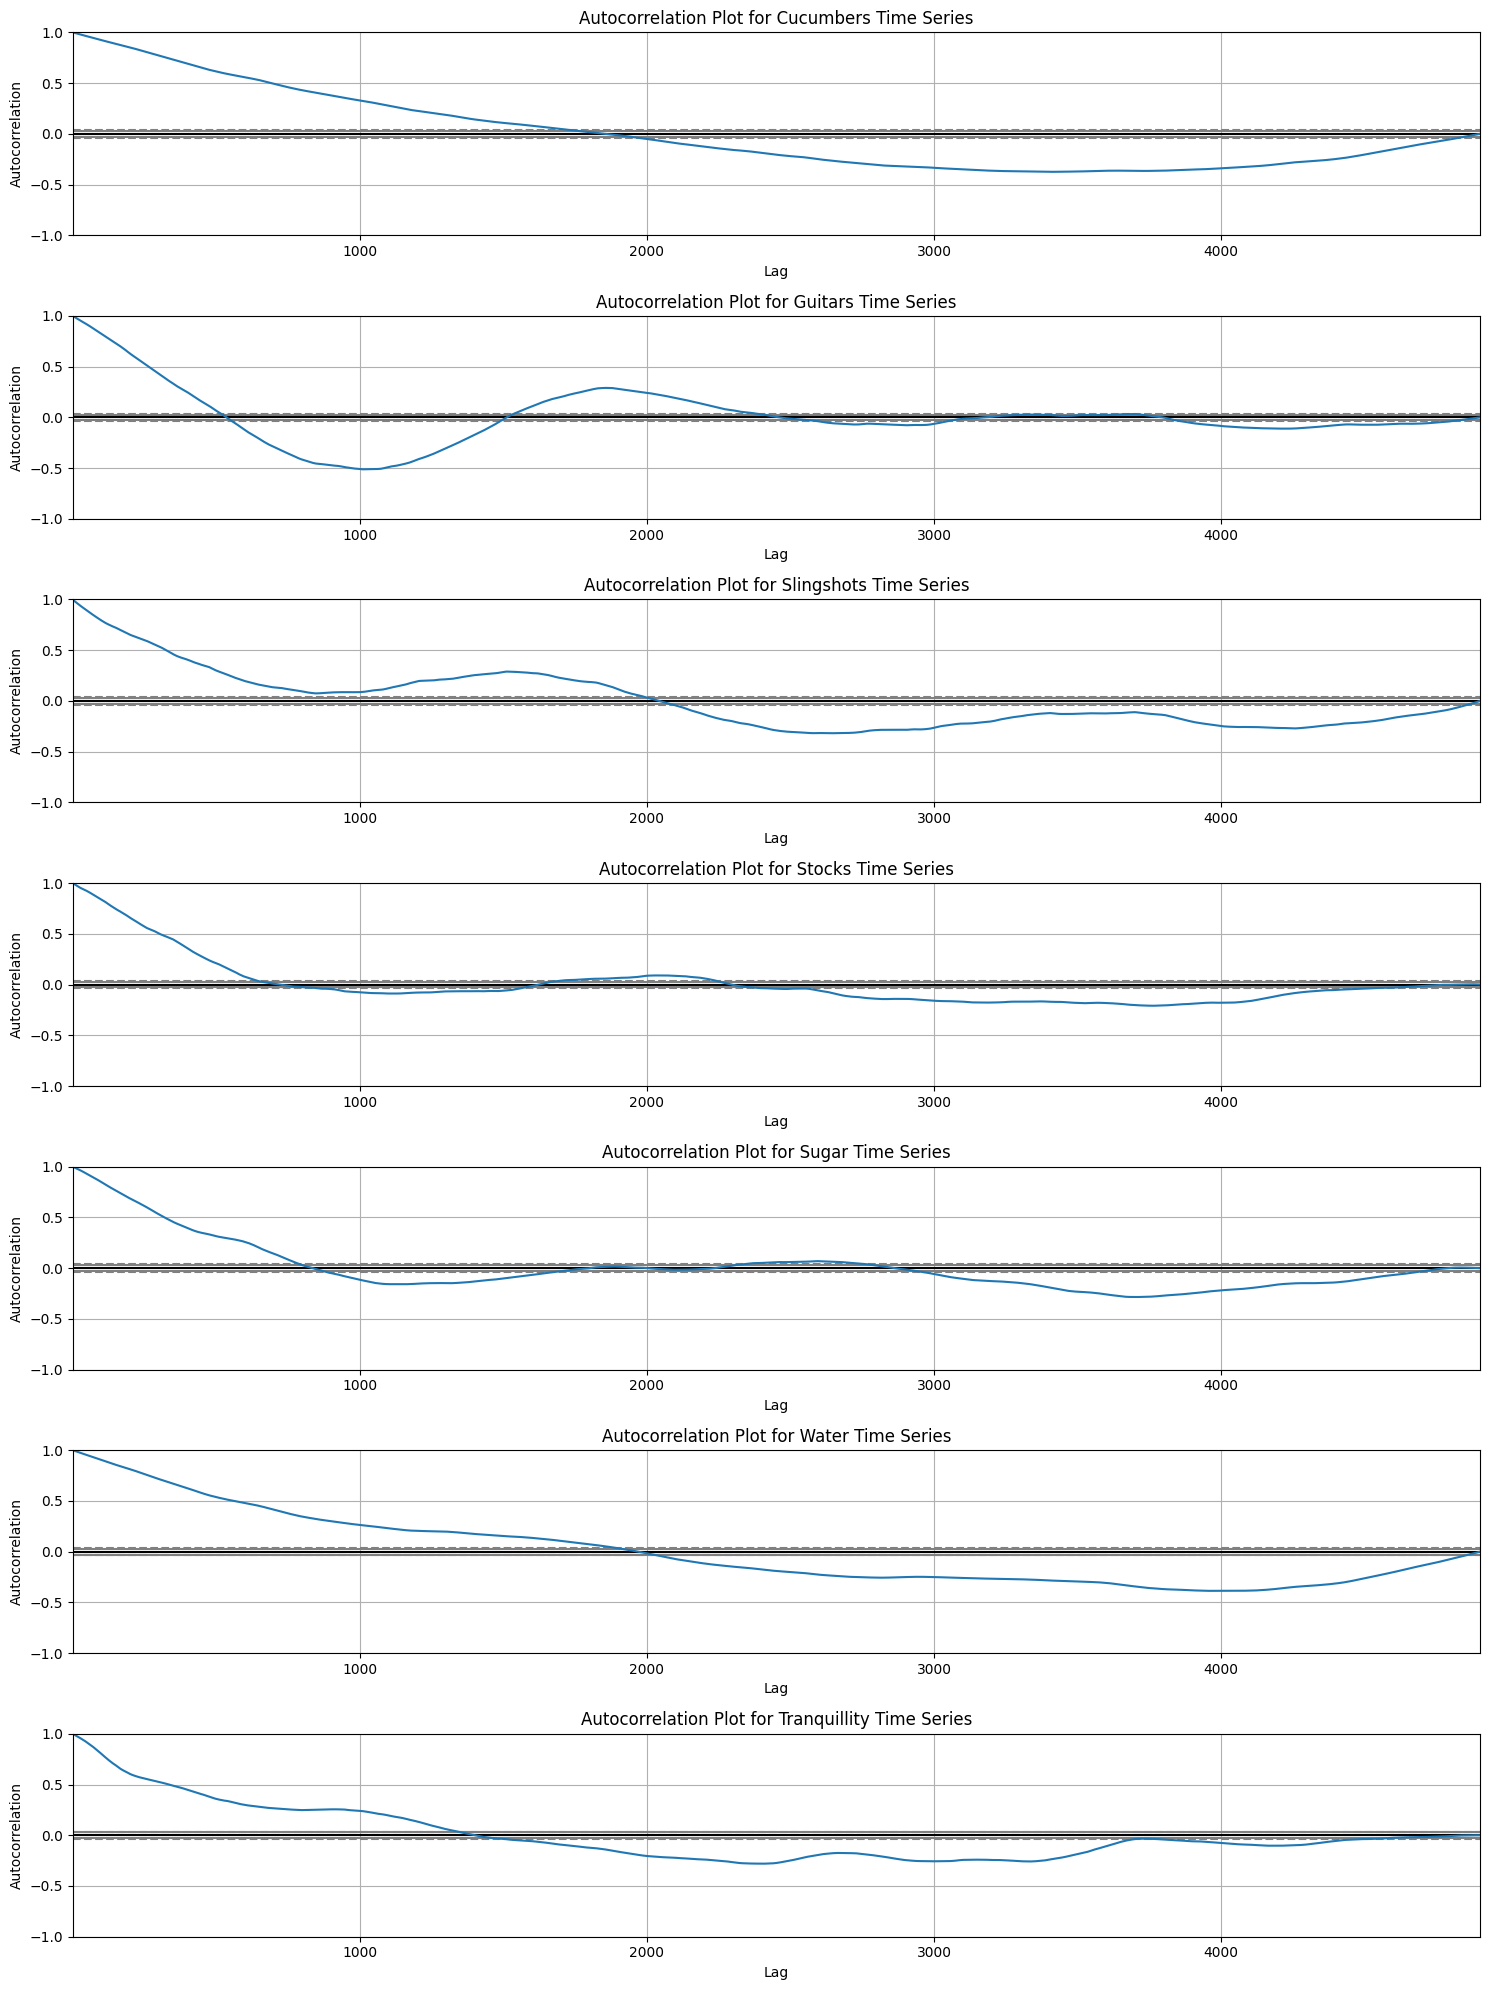

{'cucumbers': 1,
 'guitars': 1,
 'slingshots': 1,
 'stocks': 1,
 'sugar': 1,
 'water': 1,
 'tranquillity': 1}

In [7]:
from pandas.plotting import autocorrelation_plot
# List of time series columns (excluding 'day')
time_series_columns = ['cucumbers', 'guitars', 'slingshots', 'stocks', 'sugar', 'water', 'tranquillity']

# Plot autocorrelation for each filled time series
plt.figure(figsize=(15, 20))
for i, col in enumerate(time_series_columns, 1):
    plt.subplot(len(time_series_columns), 1, i)
    autocorrelation_plot(df[f'{col}'])
    plt.title(f'Autocorrelation Plot for {col.capitalize()} Time Series')
plt.tight_layout()
plt.show()
# Function to find the first significant peak in autocorrelation after lag 0
def find_seasonal_lag(series, max_lag=1000):
    autocorr = [series.autocorr(lag) for lag in range(1, max_lag)]
    # Find peaks above a threshold (e.g., 0.1) to identify seasonality
    peaks = [lag for lag, val in enumerate(autocorr, 1) if val > 0.1]
    if peaks:
        return peaks[0]
    else:
        return None

# Find seasonal lags for each time series
seasonal_lags = {}
max_lag_to_check = 1000  # Limit lag search for performance
for col in time_series_columns:
    lag = find_seasonal_lag(df[f'{col}'], max_lag=max_lag_to_check)
    seasonal_lags[col] = lag

seasonal_lags

In [8]:
from statsmodels.tsa.stattools import acf

# Function to find the best seasonal lag based on the highest significant autocorrelation peak
def best_seasonal_lag(series, max_lag=365):
    acf_values, confint = acf(series, nlags=max_lag, alpha=0.05)
    # Ignore lag 0 and find the lag with the highest autocorrelation above confidence interval
    significant_lags = [(lag, val) for lag, val in enumerate(acf_values[1:], 1) if val > confint[lag][1]]
    if significant_lags:
        best_lag = max(significant_lags, key=lambda x: x[1])[0]
        return best_lag
    else:
        return None

# Find best seasonal lag for each time series
best_lags = {}
max_lag_to_check = 365*7
for col in time_series_columns:
    lag = best_seasonal_lag(df[f'{col}'], max_lag=max_lag_to_check)
    best_lags[col] = lag

best_lags

{'cucumbers': None,
 'guitars': None,
 'slingshots': None,
 'stocks': None,
 'sugar': None,
 'water': None,
 'tranquillity': None}

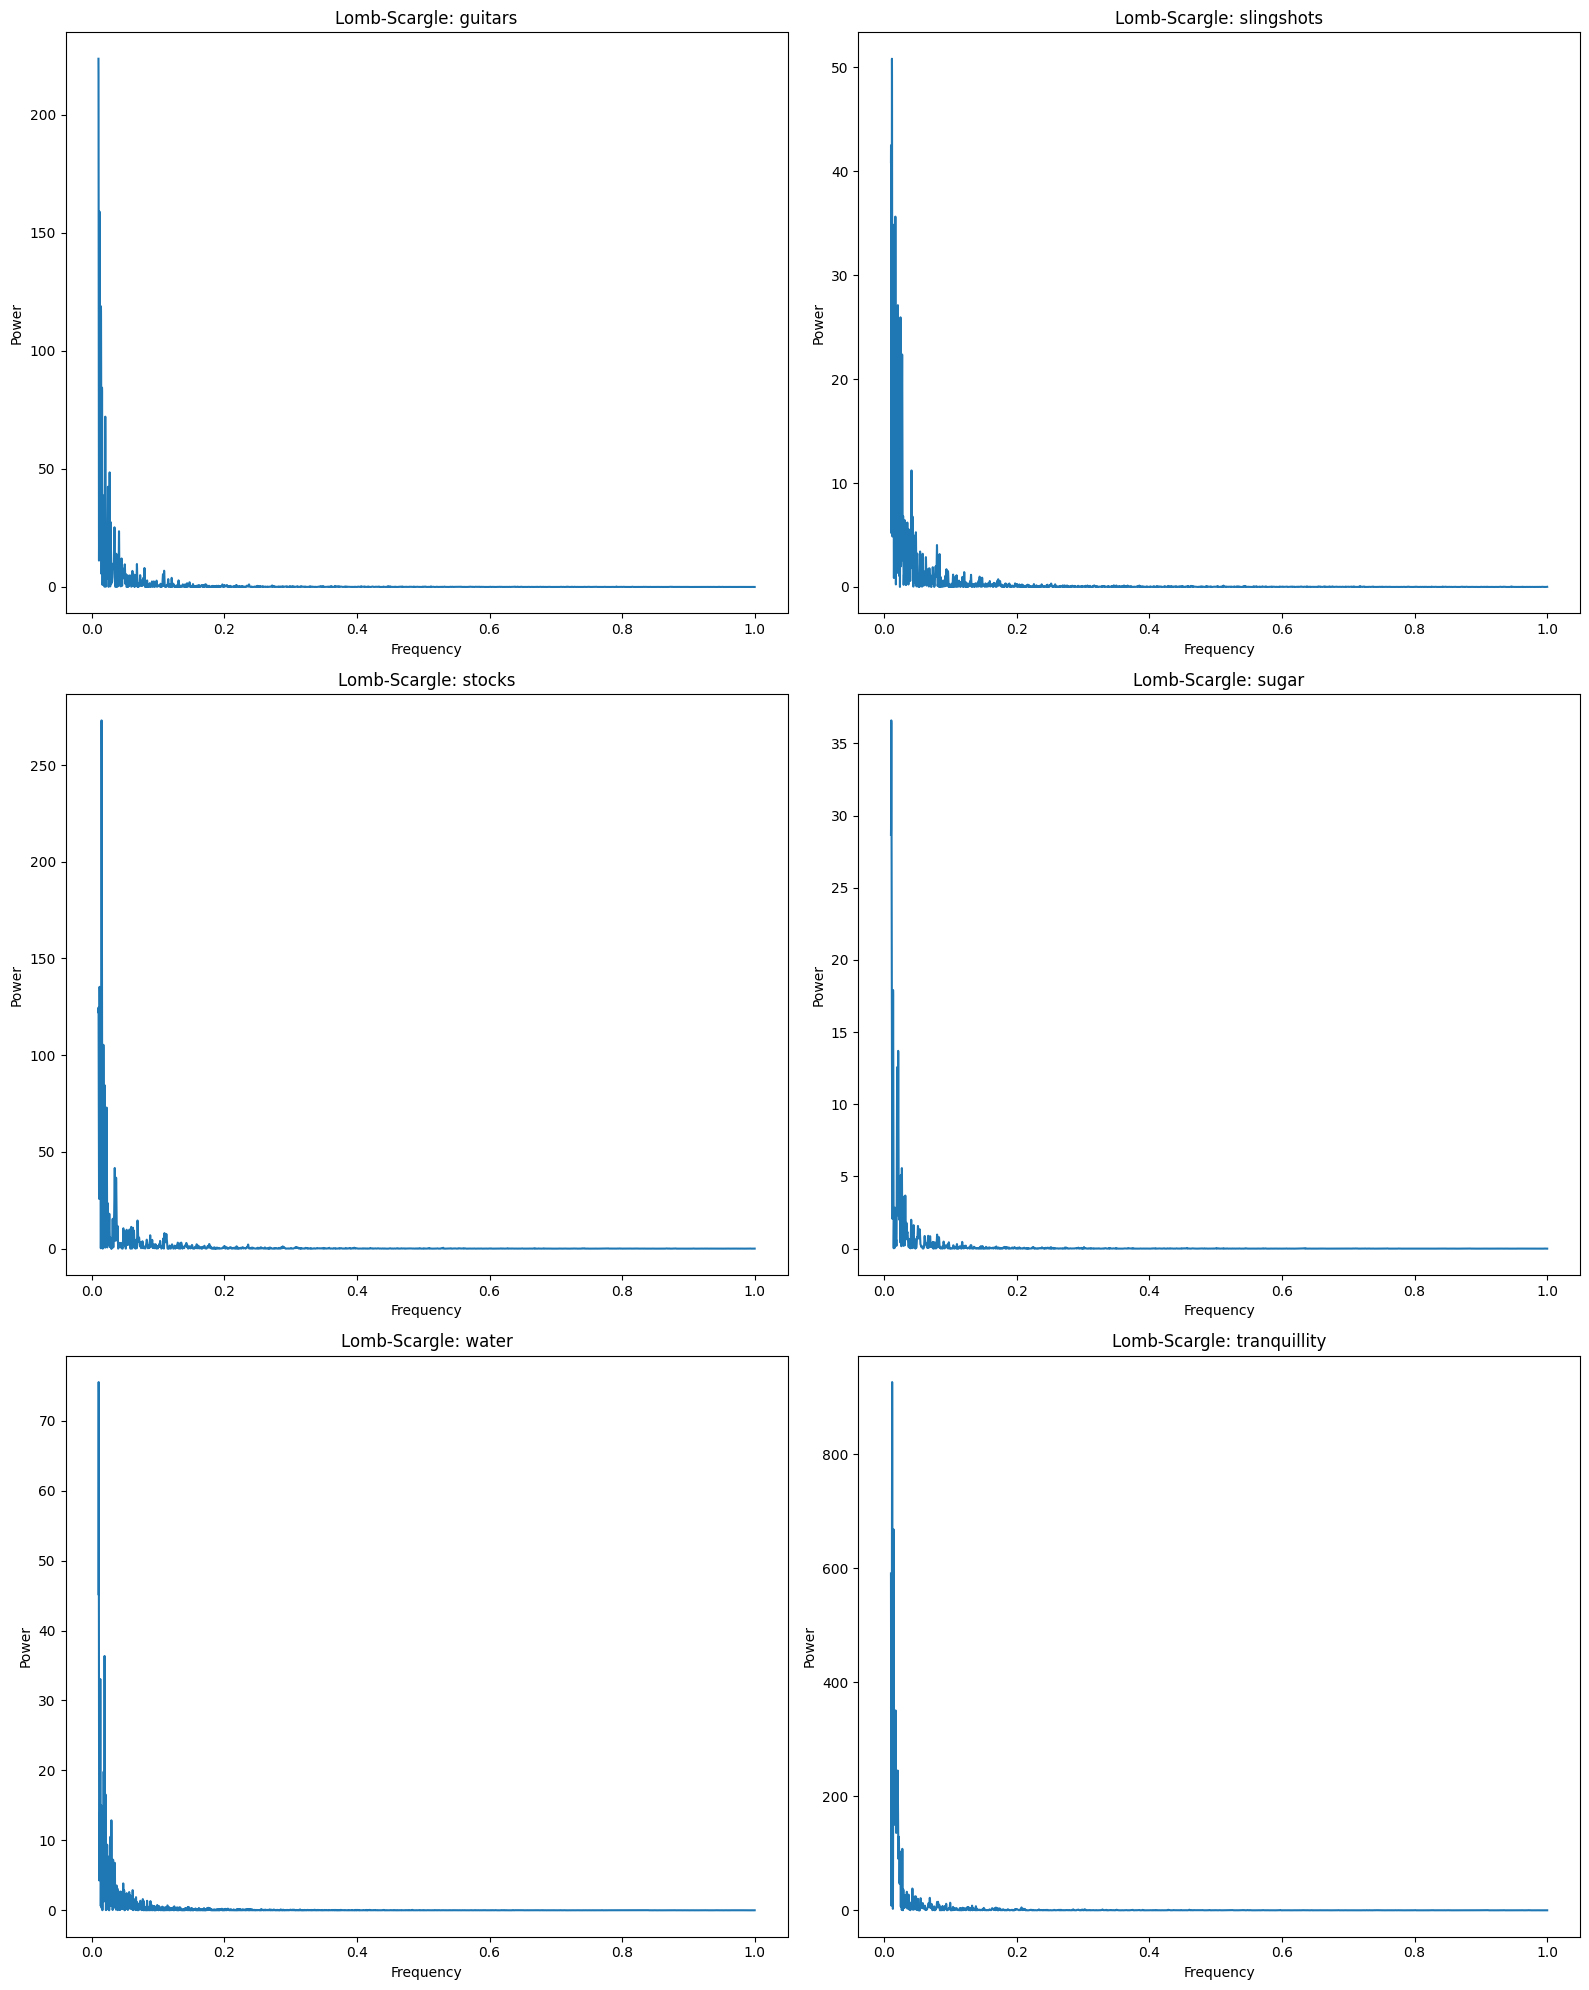


Top Frequency Peaks (cycles/day):
guitars: [0.01   0.0101 0.0102]
slingshots: [0.01149 0.01158 0.01139]
stocks: [0.01465 0.01455 0.01475]
sugar: [0.0105  0.01059 0.0104 ]
water: [0.0103 0.0104 0.0102]
tranquillity: [0.01178 0.01168 0.01188]


In [9]:
# === Lomb-Scargle Periodograms ===
frequencies = np.linspace(0.01, 1.0, 10000)
plt.figure(figsize=(16, 20))
top_peaks = {}

for i, col in enumerate(df.columns[2:], start=1):
    y = df[col].values
    t = np.arange(len(y))
    y_centered = y - np.nanmean(y)
    y_filled = np.nan_to_num(y_centered)
    power = lombscargle(t, y_filled, frequencies)

    plt.subplot((len(df.columns) - 2 + 1) // 2, 2, i)
    plt.plot(frequencies, power)
    plt.title(f"Lomb-Scargle: {col}")
    plt.xlabel("Frequency")
    plt.ylabel("Power")

    top_idx = np.argsort(power)[-3:][::-1]
    top_freqs = frequencies[top_idx]
    top_peaks[col] = top_freqs

plt.tight_layout()
plt.show()

# Print top frequency peaks
print("\nTop Frequency Peaks (cycles/day):")
for col, freqs in top_peaks.items():
    print(f"{col}: {np.round(freqs, 5)}")

In [14]:
# Set 'day' as index. If you have real dates, adjust appropriately.
if 'day' in df.columns:
    # If your days represent time steps, you can convert them to datetime (e.g., daily frequency)
    df['day'] = pd.to_numeric(df['day'], errors='coerce')
    df.sort_values('day', inplace=True)
    df.set_index('day', inplace=True)
    # Optionally, if you have a real date representation you can do:
    # df.index = pd.to_datetime(df.index, unit='D', origin='your_start_date')

In [11]:

# === Interpolation ===
log_returns_interp = log_returns.interpolate(method='linear', limit_direction='both')
df_cleaned = np.exp(log_returns_interp.cumsum()) * df.iloc[0]


In [19]:
# -------------------------
# Forecasting Settings:
# -------------------------
future_steps = 200  # Number of steps to forecast
forecasts = {}     # To store ARIMA forecasts for each series
df.index = pd.date_range(start="1970-01-01", periods=len(df), freq="D")
# -------------------------
# Loop through each series (column)
# -------------------------
for col in df.columns:
    print(f"\n--- Forecasting for series: {col} ---")
    series = df[col].dropna()
    
    # Fit ARIMA model (order can be customized)
    try:
        model = ARIMA(series, order=(1, 1, 1))
        fit_arima = model.fit()
    except Exception as e:
        print(f"ARIMA model failed for {col} with error: {e}")
        continue

    # Generate ARIMA forecast
    forecast_obj = fit_arima.get_forecast(steps=future_steps)
    forecast_mean = forecast_obj.predicted_mean
    print(f"ARIMA forecast for {col}:")
    print(forecast_mean)

    # Residual diagnostics for ARCH test:
    resid = fit_arima.resid.dropna()
    # Rescale residuals to help parameter convergence for GARCH.
    resid_scaled = (resid - resid.mean()) / resid.std()
    
    arch_needed = False
    if len(resid_scaled) < 10 or np.isclose(resid_scaled.var(), 0):
        print("Residuals too few or variance ≈ 0 – skipping ARCH test.")
    else:
        max_lag = min(20, len(resid_scaled) // 5)
        lb_p = acorr_ljungbox(resid_scaled, lags=[max_lag], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(resid_scaled, nlags=min(10, max_lag))[1]
        print(f"Ljung-Box p-value: {lb_p:.3f} (lag {max_lag})")
        print(f"ARCH-LM    p-value: {arch_p:.3f}")
        if arch_p < 0.05:
            arch_needed = True

    # Conditional GARCH fit if ARCH effects are present
    if arch_needed:
        print("Significant ARCH effects detected. Fitting GARCH model on ARIMA residuals...")
        try:
            garch_model = arch_model(resid_scaled, mean="Zero", p=1, q=1)
            garch_fit = garch_model.fit(disp="off")
            print("GARCH fit summary:")
            print(garch_fit.summary())
            # Forecast volatility (variance) for future_steps:
            garch_forecast = garch_fit.forecast(horizon=future_steps)
            # Extract forecasted variance from the last row:
            forecast_variance = garch_forecast.variance.iloc[-1]
            print("GARCH volatility forecast (variance):")
            print(forecast_variance)
        except Exception as e:
            print(f"GARCH model failed for {col} with error: {e}")

    # Store ARIMA forecast for later use or plotting
    forecasts[col] = forecast_mean

# -------------------------
# Combine all forecasts into a DataFrame for display
# -------------------------
forecast_df = pd.DataFrame(forecasts)
print("\nForecasts for all series (ARIMA predicted means):")
print(forecast_df)


--- Forecasting for series: day ---


c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

ARIMA forecast for day:
5455    5456.999998
5456    5457.999995
5457    5458.999993
5458    5459.999990
5459    5460.999988
           ...     
5650    5651.999316
5651    5652.999312
5652    5653.999307
5653    5654.999303
5654    5655.999298
Name: predicted_mean, Length: 200, dtype: float64
Ljung-Box p-value: 0.000 (lag 20)
ARCH-LM    p-value: 1.000

--- Forecasting for series: cucumbers ---


c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been prov

ARIMA forecast for cucumbers:
5201    13.791726
5202    13.791673
5203    13.791661
5204    13.791658
5205    13.791658
          ...    
5396    13.791657
5397    13.791657
5398    13.791657
5399    13.791657
5400    13.791657
Name: predicted_mean, Length: 200, dtype: float64
Ljung-Box p-value: 1.000 (lag 20)
ARCH-LM    p-value: 0.000
Significant ARCH effects detected. Fitting GARCH model on ARIMA residuals...
GARCH fit summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2064.29
Distribution:                  Normal   AIC:                           4134.58
Method:            Maximum Likelihood   BIC:                           4154.25
                                        No. Observations:                 5201
Date:        

c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been prov

ARIMA forecast for guitars:
5201    8.084851
5202    8.084851
5203    8.084851
5204    8.084851
5205    8.084851
          ...   
5396    8.084851
5397    8.084851
5398    8.084851
5399    8.084851
5400    8.084851
Name: predicted_mean, Length: 200, dtype: float64
Ljung-Box p-value: 0.027 (lag 20)
ARCH-LM    p-value: 0.000
Significant ARCH effects detected. Fitting GARCH model on ARIMA residuals...
GARCH fit summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5844.36
Distribution:                  Normal   AIC:                           11694.7
Method:            Maximum Likelihood   BIC:                           11714.4
                                        No. Observations:                 5201
Date:                Wed, 

c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been prov

ARIMA forecast for slingshots:
5201    6.415105
5202    6.415926
5203    6.415754
5204    6.415790
5205    6.415782
          ...   
5396    6.415784
5397    6.415784
5398    6.415784
5399    6.415784
5400    6.415784
Name: predicted_mean, Length: 200, dtype: float64
Ljung-Box p-value: 0.026 (lag 20)
ARCH-LM    p-value: 0.000
Significant ARCH effects detected. Fitting GARCH model on ARIMA residuals...
GARCH fit summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5565.13
Distribution:                  Normal   AIC:                           11136.3
Method:            Maximum Likelihood   BIC:                           11155.9
                                        No. Observations:                 5201
Date:                We

c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been prov

ARIMA forecast for stocks:
5201    6.512971
5202    6.512971
5203    6.512971
5204    6.512971
5205    6.512971
          ...   
5396    6.512971
5397    6.512971
5398    6.512971
5399    6.512971
5400    6.512971
Name: predicted_mean, Length: 200, dtype: float64
Ljung-Box p-value: 0.988 (lag 20)
ARCH-LM    p-value: 0.000
Significant ARCH effects detected. Fitting GARCH model on ARIMA residuals...
GARCH fit summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4040.25
Distribution:                  Normal   AIC:                           8086.49
Method:            Maximum Likelihood   BIC:                           8106.16
                                        No. Observations:                 5201
Date:                Wed, M

c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been prov

ARIMA forecast for sugar:
5201    2.766475
5202    2.768263
5203    2.768806
5204    2.768971
5205    2.769021
          ...   
5396    2.769043
5397    2.769043
5398    2.769043
5399    2.769043
5400    2.769043
Name: predicted_mean, Length: 200, dtype: float64
Ljung-Box p-value: 0.999 (lag 20)
ARCH-LM    p-value: 0.000
Significant ARCH effects detected. Fitting GARCH model on ARIMA residuals...
GARCH fit summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4594.47
Distribution:                  Normal   AIC:                           9194.94
Method:            Maximum Likelihood   BIC:                           9214.61
                                        No. Observations:                 5201
Date:                Wed, Ma

c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been prov

ARIMA forecast for water:
5201    8.738561
5202    8.738561
5203    8.738561
5204    8.738561
5205    8.738561
          ...   
5396    8.738561
5397    8.738561
5398    8.738561
5399    8.738561
5400    8.738561
Name: predicted_mean, Length: 200, dtype: float64
Ljung-Box p-value: 1.000 (lag 20)
ARCH-LM    p-value: 0.000
Significant ARCH effects detected. Fitting GARCH model on ARIMA residuals...
GARCH fit summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1733.55
Distribution:                  Normal   AIC:                           3473.09
Method:            Maximum Likelihood   BIC:                           3492.76
                                        No. Observations:                 5201
Date:                Wed, Ma

c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [20]:

# === Sharpe Ratio Function ===
def sharpe_ratio(returns, risk_free=0.03, periods_per_year=252):
    excess = returns - risk_free / periods_per_year
    return np.mean(excess) / np.std(excess)

# === Investment Strategies ===
strategies = {}

for col in df_cleaned.columns[2:]:
    price = df_cleaned[col]
    returns = price.pct_change().dropna()

    # Buy & Hold
    bh = returns.copy()
    sharpe_bh = sharpe_ratio(bh)

    # Moving Average Crossover
    ma_fast = price.rolling(10).mean()
    ma_slow = price.rolling(50).mean()
    position_ma = (ma_fast > ma_slow).astype(int).shift(1).fillna(0)
    strat_ma = position_ma * returns
    sharpe_ma = sharpe_ratio(strat_ma)

    # Buy-the-Dip
    dip_signal = (returns.shift(1) < 0).astype(int)
    strat_dip = dip_signal * returns
    sharpe_dip = sharpe_ratio(strat_dip)

    # Channel Breakout
    N = 20
    high_roll = price.rolling(N).max()
    low_roll = price.rolling(N).min()
    breakout_pos = (price > high_roll.shift(1)).astype(int)
    exit_pos = (price < low_roll.shift(1)).astype(int)
    position_cb = breakout_pos.copy()
    position_cb[exit_pos == 1] = 0
    position_cb = position_cb.ffill().fillna(0)
    strat_cb = position_cb * returns
    sharpe_cb = sharpe_ratio(strat_cb)

    strategies[col] = {
        "BuyHold": sharpe_bh,
        "MA_Crossover": sharpe_ma,
        "Buy_the_Dip": sharpe_dip,
        "Channel_Breakout": sharpe_cb
    }

# Print Strategy Results
print("\nSharpe Ratios for All Strategies:")
print(pd.DataFrame(strategies).T)



Sharpe Ratios for All Strategies:
               BuyHold  MA_Crossover  Buy_the_Dip  Channel_Breakout
guitars       0.010312      0.022535    -0.015798          0.309833
slingshots    0.029327      0.053269     0.006821          0.334286
stocks       -0.037323     -0.017426    -0.057245          0.280010
sugar        -0.085207     -0.008838    -0.104043          0.268165
tranquillity  0.025054      0.038813    -0.017420          0.317159
water         0.009410     -0.002871    -0.013724          0.270440
